In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import csv

from matplotlib_venn import venn3
from matplotlib_venn import venn2
from matplotlib_venn import venn2_circles

import cooler
import bioframe
from scipy.spatial.distance import pdist, squareform
from matplotlib.colors import LogNorm
from matplotlib.ticker import EngFormatter


bp_formatter = EngFormatter('b')

In [2]:
def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

In [3]:
# peaks
smc1_ca1200 = bioframe.read_table('/home/kimj50/cohesin_paper/SMC1_SMC3_chips/MACSoutput/SMC1_Q4467_CA1200_1hrauxin_avg_JK159b_JK160b_chip_peaks.bed',schema='bed9',index_col=False)
smc3_ca1200 = bioframe.read_table('/home/kimj50/cohesin_paper/SMC1_SMC3_chips/MACSoutput/SMC3_Q4469_CA1200_1hrauxin_avg_JK165_JK166_chip_peaks.bed',schema='bed9',index_col=False)

smc1_jk06 = bioframe.read_table('/home/kimj50/cohesin_paper/SMC1_SMC3_chips/MACSoutput/SMC1_Q4467_JK06_1hrauxin_avg_JK161b_JK184b_chip_peaks.bed',schema='bed9',index_col=False)
smc3_jk06 = bioframe.read_table('/home/kimj50/cohesin_paper/SMC1_SMC3_chips/MACSoutput/SMC3_Q4469_JK06_1hrauxin_avg_JK167_JK185_chip_peaks.bed',schema='bed9',index_col=False)


/ext3/miniconda3/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


In [4]:
u = bioframe.read_table('/home/kimj50/cohesin_paper/_notebook_v1/output/c_elegans.WS220.annotations_gtf_genes_codingtranscript_v2.bed', schema='bed6')
jets = bioframe.read_table('/home/kimj50/cohesin_paper/jets_call/jetcall_v5_w30kb.bed',schema='bed6')
jets['chrom'] = 'chr' + jets['chrom']
jets['mid']=(jets['start']+jets['start'])//2
jets['mid_1']=jets['mid']+1


In [5]:
###### only keep genes that have macs called peak ######
a = bioframe.count_overlaps(u,smc1_ca1200)['count']>0
b = bioframe.count_overlaps(u,smc3_ca1200)['count']>0
c = bioframe.count_overlaps(u,smc1_jk06)['count']>0
d = bioframe.count_overlaps(u,smc3_jk06)['count']>0

u_peaks= u[np.logical_or(np.logical_or(np.logical_or(a,b),c),d)].reset_index(drop=True)

u_peaks

,chrom,start,end,name,score,strand
0,chrI,4119,10232,Y74C9A.3,0,-
1,chrI,10413,16842,Y74C9A.2,0,+
2,chrI,17483,26781,Y74C9A.4,0,-
3,chrI,27595,32482,Y74C9A.5,0,-
4,chrI,47472,49819,Y48G1C.12,0,+
...,...,...,...,...,...,...
6265,chrX,17528335,17531906,R09G11.1,0,+
6266,chrX,17532861,17533991,F31A3.3,0,-
6267,chrX,17622636,17640667,H18N23.2,0,-
6268,chrX,17714380,17714756,6R55.2,0,+


In [6]:
#u_peaks.to_csv("./highlow/c_elegans.WS220.annotations_gtf_genes_codingtranscript_v2_smcPeakinctrwapl.bed", sep="\t", quoting=csv.QUOTE_NONE,header=False,index=False)
# use this bed6 file to get cohesin enrichment across genes using deepTools

In [7]:
# read deeptools output matrix
v = pd.read_csv('/scratch/cgsb/ercan/Jun_cohesin/scratch_cohesin_paper/highlow/multi_smcPeakinctrwapl.tab',sep='\t')
v.columns = ['chrom','start','end','smc1_ca1200','smc3_ca1200','smc1_jk06','smc3_jk06']
v

,chrom,start,end,smc1_ca1200,smc3_ca1200,smc1_jk06,smc3_jk06
0,chrI,4119,10232,0.299746,-0.156735,0.752060,0.119033
1,chrI,10413,16842,0.683239,0.469982,0.705833,0.385300
2,chrI,17483,26781,0.726261,0.399167,0.980973,0.582678
3,chrI,27595,32482,0.918976,0.386265,0.082888,-0.250921
4,chrI,47472,49819,0.393947,-0.143184,0.162299,0.115117
...,...,...,...,...,...,...,...
6265,chrX,17528335,17531906,1.167551,0.463423,0.083452,-0.305783
6266,chrX,17532861,17533991,-0.174958,-0.359754,-0.475965,-0.395164
6267,chrX,17622636,17640667,1.461808,1.174944,0.881435,0.753651
6268,chrX,17714380,17714756,2.923707,-0.003352,3.128851,1.163712


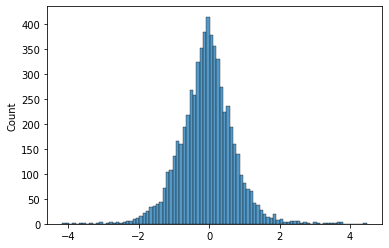

In [8]:
# take average of replicates and compute difference
v['ca1200'] = (v.smc1_ca1200+v.smc3_ca1200)/2
v['jk06'] = (v.smc1_jk06+v.smc3_jk06)/2

v['mid'] = (v.start+v.end)//2
v['mid_1'] = (v.start+v.end)//2+1
t = bioframe.closest(v,jets,cols1=('chrom','mid','mid_1'),cols2=('chrom','mid','mid_1'))


sns.histplot(v.ca1200 - v.jk06)
t_ctr = t[v.ca1200-v.jk06 > 0]
t_wapl = t[v.ca1200-v.jk06 < 0]


In [9]:
######### subset within jet range first of 40kb
D = 40_000
D0 = 20_000_000

D_bool = t.distance<D
D0_bool = t.distance<D0
ctr_bool = (t.ca1200_1 - t.jk06_1) > 0
wapl_bool = (t.ca1200_1 - t.jk06_1) < 0

u_peaks['ctr'] = t.ca1200_1
u_peaks['wapl'] = t.jk06_1
u_peaks['distance'] = t.distance

u_peaks_ctr = u_peaks[np.logical_and(D_bool,ctr_bool)]
u_peaks_wapl = u_peaks[np.logical_and(D_bool,wapl_bool)]

u_peaks_ctr_all = u_peaks[np.logical_and(D0_bool,ctr_bool)]
u_peaks_wapl_all = u_peaks[np.logical_and(D0_bool,wapl_bool)]



print(len(u_peaks_ctr),len(u_peaks_wapl))
#D=40_000: 851,1326
#D=20_000_000: 2902, 3348
print(100*len(u_peaks_ctr)/len(u_peaks_ctr_all), 100*len(u_peaks_wapl)/len(u_peaks_wapl_all), 'percent genes within 40kb jet')
print(len(jets)*80_000 / 100_000_000 * 100)

851 1326
29.32460372157133 39.60573476702509 percent genes within 40kb jet
22.96


In [10]:
# the two gene groups to be plotted on deeptools

#u_peaks_ctr.to_csv("./highlow/c_elegans.WS220.annotations_gtf_genes_codingtranscript_controlhigh_values_within40kbjet.bed", sep="\t", quoting=csv.QUOTE_NONE,header=False,index=False)
#u_peaks_wapl.to_csv("./highlow/c_elegans.WS220.annotations_gtf_genes_codingtranscript_waplhigh_values_within40kbjet.bed", sep="\t", quoting=csv.QUOTE_NONE,header=False,index=False)


851
851
1326
1326


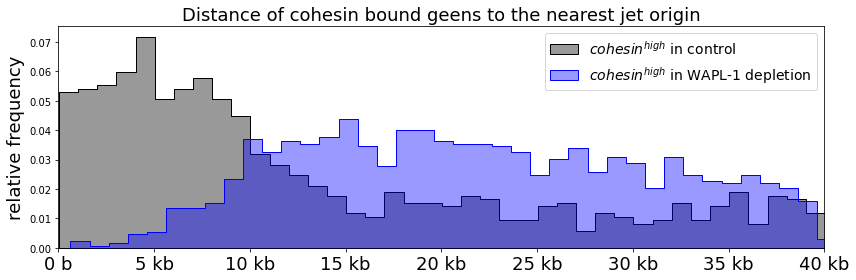

In [11]:
### n peaks, center
f, axs = plt.subplots(
    figsize=(12, 4),
    nrows=1,
    ncols=1,
    sharey='row'
)


Label_1 = '$cohesin^{high}$ in control'
Label_2 = '$cohesin^{high}$ in WAPL-1 depletion'
Labels = [Label_1,Label_2]
Colors = ['black','blue']
D = 40_000

dats = [u_peaks_ctr,u_peaks_wapl]


for i in range(len(dats)):
    print(len(dats[i]))
    vals = dats[i].distance[dats[i].distance<D]
    print(len(vals))
    a = sns.histplot(ax=axs,data = vals, kde = False, label=Labels[i],
                     stat = "probability",color=Colors[i],alpha=0.4,binwidth=1000,element='step')


a.set_title('Distance of cohesin bound geens to the nearest jet origin',fontsize=18)
a.set_xlabel('')
format_ticks(a,x=True,y=False,rotate=False)
plt.xticks(fontsize=18)
a.set_xlim(0,D)

a.legend(prop={'size': 14})
a.set_ylabel('relative frequency' ,rotation=90,fontsize=18,labelpad=4)

#f.text(0.53, -0.03, 'distance between the gene and the nearest jet origin', 
#       ha='center',fontsize=18)

#ax.semilogx()
plt.tight_layout()